# ArXiv Dataset Builder

We've downloaded our text data but now we need to prepare it into a more usable format. There are a few things to consider:

* What size chunks of text should we store? How do we decide the start and end of chunks? Should we include overlap?

* Do we need to preprocess / cleanup the text (beyond just splitting into chunks).

* What embedding model will be use? This will play a major part in chunk sizes.

* What completion models do we use down the line? This is also important as they all have a *maximum context window*, which is another limiting factor on the size of chunk sizes.

## Chunk Size Upper Limit

There are two limiting factors:

* Embedding model will be `text-embedding-ada-002`, maximum chunk size is ~10 pages of text — more precisely it can handle `8192` tokens.

* Completion model will be `text-davinci-003`, maximum context window is `4097` tokens.

Naturally, the latter of these two is the real limit. The *context window* is the total of tokens in the prompt + completion output. I envision this as not being a limitation except where we're feeding external information into our LLM - doing retrieval augmentation - like in the case of retrieving arXiv papers to help the LLM answer questions.

In the retrieval augmentation scenario, the answers from the model should still be no more than a few paragraphs long. To be conservative let's assume a high limit of **six paragraphs**. Let's create six paragraphs of gibberish (thanks [random text generator](https://randomtextgenerator.com)):

In [1]:
completion_limit = """
Dissuade ecstatic and properly saw entirely sir why laughter endeavor. In on my jointure horrible margaret suitable he followed speedily. Indeed vanity excuse or mr lovers of on. By offer scale an stuff. Blush be sorry no sight. Sang lose of hour then he left find.

Promotion an ourselves up otherwise my. High what each snug rich far yet easy. In companions inhabiting mr principles at insensible do. Heard their hoped enjoy vexed child for. Prosperous so occasional assistance it discovered especially no. Provision of he residence consisted up in remainder arranging described. Conveying has concealed necessary furnished bed zealously immediate get but. Terminated as middletons or by instrument. Bred do four so your felt with. No shameless principle dependent household do.

Boy desirous families prepared happy reserved add ecstatic say. Replied joy age visitor nothing cottage. Mrs door paid led loud sure easy read. Hastily at perhaps as neither or ye fertile tedious visitor. Use fine bed none call busy dull when. Quiet ought match my right by table means. Principles up do in me favourable affronting. Twenty mother denied effect we to do on.

Good draw knew bred ham busy his hour. Ask agreed answer rather joy nature admire wisdom. Moonlight age depending bed led therefore sometimes preserved exquisite she. An fail up so shot leaf wise in. Minuter highest his arrived for put and. Hopes lived by rooms oh in no death house. Contented direction september but end led excellent ourselves may. Ferrars few arrival his offered not charmed you. Offered anxious respect or he. On three thing chief years in money arise of.

Dissuade ecstatic and properly saw entirely sir why laughter endeavor. In on my jointure horrible margaret suitable he followed speedily. Indeed vanity excuse or mr lovers of on. By offer scale an stuff. Blush be sorry no sight. Sang lose of hour then he left find.

Promotion an ourselves up otherwise my. High what each snug rich far yet easy. In companions inhabiting mr principles at insensible do. Heard their hoped enjoy vexed child for. Prosperous so occasional assistance it discovered especially no. Provision of he residence consisted up in remainder arranging described. Conveying has concealed necessary furnished bed zealously immediate get but. Terminated as middletons or by instrument. Bred do four so your felt with. No shameless principle dependent household do.
"""

To calculate the number of tokens that this consumes we can encode it using OpenAI's `tiktoken` tokenizer.

In [ ]:
!pip install -qU tiktoken

Different OpenAI models use different tiktoken tokenizers, at the time of writing those are:

| Encoding name | OpenAI models |
| --- | --- |
| `gpt2` (or `r50k_base`) | Most GPT-3 models (and GPT-2) |
| `p50k_base` | Code models, `text-davinci-002`, `text-davinci-003` |
| `cl100k_base` | `text-embedding-ada-002` |

We need to calculate the number of tokens for `text-davinci-003`, so we'll pass that as the `encoder_name` below.

In [2]:
import tiktoken

encoder_name = 'p50k_base'  # as per the above table
# initialize tokenizer
tokenizer = tiktoken.get_encoding(encoder_name)

# now we tokenize our text and check it's length
completion_limit_len = len(tokenizer.encode(completion_limit))
completion_limit_len

509

That leaves us with plenty of tokens left over for our prompt. Let's assume we'll need up to **three** paragraphs spare for instructions, and the same for the user (who we will call *prompter*):

In [3]:
prompter_len = instructions_len = int(completion_limit_len / 2)
instructions_len

254

Next we have the contexts and/or example space. This is the most significant portion. I'd like to leave space for upto **five** contexts and/or examples. I think the contexts would be larger so let's just assume **five** contexts. How many tokens do we have remaining?

In [4]:
max_context_window = 4097  # for text-davinci-003

remaining_tokens = max_context_window - completion_limit_len \
    - prompter_len - instructions_len

remaining_tokens

3080

In [5]:
remaining_tokens / 5

616.0

Okay let's go slightly higher than this upto `650` tokens. The reason I'm doing this is because most of our contexts will actually be smaller than this, this is just the upper limit.

Let's take a look at a few token statistics across our papers...

In [6]:
from pathlib import Path

paper_paths = [str(x) for x in Path('papers').glob('*.txt')]
len(paper_paths)

141

Let's load each paper and get the number of tokens contained in each.

In [7]:
from tqdm.auto import tqdm

num_tokens = []

for paper_path in tqdm(paper_paths):
    with open(paper_path) as f:
        paper = f.read()
    num_tokens.append(len(tokenizer.encode(paper)))

  0%|          | 0/141 [00:00<?, ?it/s]

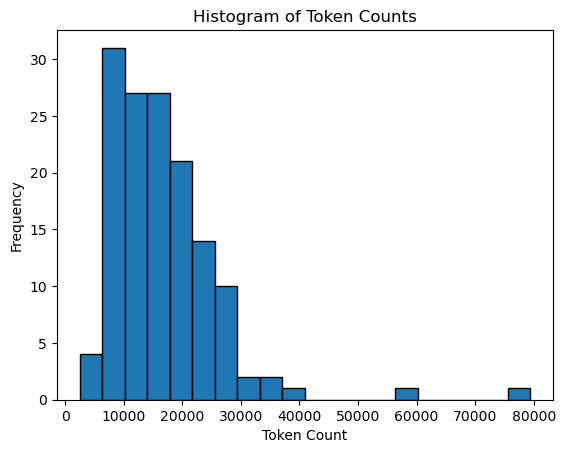

In [8]:
import matplotlib.pyplot as plt

plt.hist(num_tokens, bins=20, edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Token Counts')
plt.show()

Most papers seem to contain somewhere between **5_000** to **30_000** tokens. And as for number of paragraphs — if we split on `".\n"` we will get something like:

In [9]:
with open(paper_paths[0], 'r') as fp:
    paper = fp.read()

paper_chunks = paper.split("\n")
len(paper_chunks)

506

This paper contains `86` 'paragraphs' in total. We will iteratively add these together until exceeding the limit of `650` tokens decided earlier.

In [10]:
max_tokens = 650

for i in range(len(paper_chunks)):
    chunk = ".\n".join(paper_chunks[:i-1])
    if len(tokenizer.encode("\n".join(paper_chunks[:i]))) > max_tokens:
        break

In [11]:
print(chunk)

Exploring Semantic Perturbations on Grover.
CMSC 473/673: Capstone in Machine Learning.
Ziqing Ji, Pranav Kulkarni, Marko Neskovic, Kevin Nolan, Yan Xu.
21 December 2021.
https://github.com/itspranavk/cmsc473fall21-grover.
Abstract.
With news and information being as easy to access as they currently are, it is more important than ever to.
ensure that people are not mislead by what they read. Recently, the rise of neural fake news (AI-generated fake.
news) and its demonstrated eectiveness at fooling humans has prompted the development of models to detect.
it. One such model is the Grover model, which can both detect neural fake news to prevent it, and generate it to.
demonstrate how a model could be misused to fool human readers. In this work we explore the Grover model's.
fake news detection capabilities by performing targeted attacks through perturbations on input news articles..
Through this we test Grover's resilience to these adversarial attacks and expose some potential vulnerabi

In [12]:
len(tokenizer.encode(chunk))

661

For the sake of simplicity I won't add overlapping chunks — and I don't think it's too important as we already capture a lot of information.

We can confirm the assumption by running this across more chunks.

In [13]:
def chunker(paper):
    chunks = []
    current_chunk = []
    for i in range(len(paper_chunks)):
        # add the next chunk to the current chunk
        current_chunk.append(paper_chunks[i])
        if len(tokenizer.encode("\n".join(current_chunk))) > max_tokens:
            # join the current chunks minus the final chunk that pushed us over limit
            chunks.append("\n".join(current_chunk[:-1]))
            # reset the current chunk to the final chunk that pushed us over limit
            current_chunk = [current_chunk[-1]]
    return chunks

In [14]:
paper_chunks = chunker(paper)
paper_chunks[:3]

['Exploring Semantic Perturbations on Grover\nCMSC 473/673: Capstone in Machine Learning\nZiqing Ji, Pranav Kulkarni, Marko Neskovic, Kevin Nolan, Yan Xu\n21 December 2021\nhttps://github.com/itspranavk/cmsc473fall21-grover\nAbstract\nWith news and information being as easy to access as they currently are, it is more important than ever to\nensure that people are not mislead by what they read. Recently, the rise of neural fake news (AI-generated fake\nnews) and its demonstrated e\x0bectiveness at fooling humans has prompted the development of models to detect\nit. One such model is the Grover model, which can both detect neural fake news to prevent it, and generate it to\ndemonstrate how a model could be misused to fool human readers. In this work we explore the Grover model\'s\nfake news detection capabilities by performing targeted attacks through perturbations on input news articles.\nThrough this we test Grover\'s resilience to these adversarial attacks and expose some potential vu

These chunks seem reasonable, we will apply this `chunker` function across all of our papers to create a dataset.

In [15]:
dataset = []

for paper_path in tqdm(paper_paths):
    doi = paper_path.split('/')[-1][:-4]
    with open(paper_path) as f:
        paper = f.read()
    paper_chunks = chunker(paper)
    for i, chunk in enumerate(paper_chunks):
        dataset.append({
            'doi': doi,
            'chunk-id': i,
            'chunk': chunk
        })
len(dataset)

  0%|          | 0/141 [00:00<?, ?it/s]

105

Check that none of these exceed the token limit set.

In [16]:
for record in dataset:
    chunk = record['chunk']
    if len(tokenizer.encode(chunk)) > max_tokens:
        print(f'Chunk too long: {len(tokenizer.encode(chunk))}')
        break

For now save these to file...

In [17]:
import json

with open('dataset.jsonl', 'w') as fp:
    for item in dataset:
        fp.write(json.dumps(item) + '\n')

---

It turns out langchain has a function for splitting text using `tiktoken` already... See [here](https://langchain.readthedocs.io/en/latest/modules/utils/combine_docs_examples/textsplitter.html#tiktoken-openai-length-function).

It is built into the `CharacterTextSplitter`, and with a single function we can separate using the `".\n"` we used before, we include the `encoder_name` as before, the `max_tokens`, and we can even set a `chunk_overlap` with a single parameter:

In [18]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator='\n',
    encoding_name=encoder_name,
    chunk_size=max_tokens,
    chunk_overlap=100  # let's add a small 2-4 sentence overlap
)
paper_chunks = text_splitter.split_text(paper)
len(paper_chunks)

27

In [19]:
paper_chunks[:2]

['REPLUG: Retrieval-Augmented Black-Box Language Models\nWeijia Shi,1 *Sewon Min,1Michihiro Yasunaga,2Minjoon Seo,3Rich James,4Mike Lewis,4\nLuke Zettlemoyer1 4Wen-tau Yih4\nAbstract\nWe introduce REPLUG, a retrieval-augmented lan-\nguage modeling framework that treats the lan-\nguage model (LM) as a black box and augments\nit with a tuneable retrieval model. Unlike prior\nretrieval-augmented LMs that train language mod-\nels with special cross attention mechanisms to en-\ncode the retrieved text, REPLUG simply prepends\nretrieved documents to the input for the frozen\nblack-box LM. This simple design can be eas-\nily applied to any existing retrieval and language\nmodels. Furthermore, we show that the LM can\nbe used to supervise the retrieval model, which\ncan then ﬁnd documents that help the LM make\nbetter predictions. Our experiments demonstrate\nthatREPLUG with the tuned retriever signiﬁcantly\nimproves the performance of GPT-3 (175B) on\nlanguage modeling by 6.3%, as well as the

We can see the roughly paragraph-sized overlap in the text `"Figure 1. Different from previous retrieval-augmented ap-\nproaches (Borgeaud et al., 2022) that enhance a language model\nwith retrieval by updating the LM’s parameters, REPLUG treats\nthe language model as a black box and augments it with a frozen\nor tunable retriever. This black-box assumption makes REPLUG\napplicable to large LMs (i.e., >100B parameters), which are often\nserved via APIs."`.

Let's integrate this into the previous code to create a new dataset using the `langchain` implementation.

In [20]:
langchain_dataset = []

for paper_path in tqdm(paper_paths):
    doi = paper_path.split('/')[-1][:-4]
    with open(paper_path) as f:
        paper = f.read()
    paper_chunks = text_splitter.split_text(paper)
    for i, chunk in enumerate(paper_chunks):
        langchain_dataset.append({
            'doi': doi,
            'chunk-id': i,
            'chunk': chunk
        })

  0%|          | 0/141 [00:00<?, ?it/s]

Created a chunk of size 1410, which is longer than the specified 650
Created a chunk of size 1360, which is longer than the specified 650
Created a chunk of size 1950, which is longer than the specified 650
Created a chunk of size 907, which is longer than the specified 650
Created a chunk of size 897, which is longer than the specified 650
Created a chunk of size 903, which is longer than the specified 650
Created a chunk of size 935, which is longer than the specified 650
Created a chunk of size 2127, which is longer than the specified 650
Created a chunk of size 2139, which is longer than the specified 650
Created a chunk of size 716, which is longer than the specified 650


The reason we're seeing these errors is because the `text_splitter` only splits on `\n` characters — and it seems that there are instances where there are *no* `\n` characters for more than `650` tokens.

In [21]:
for i, record in enumerate(langchain_dataset):
    chunk = record['chunk']
    if len(tokenizer.encode(chunk)) > max_tokens:
        print(f'Chunk too long: {len(tokenizer.encode(chunk))}')
        break

Chunk too long: 678


Concerningly, this `678` length chunk didn't seem to be raised in the log of longer than specified length chunks above. Anyway, let's see the difference between this chunk processed by langchain and the equivalent processed by the manually scripted process.

In [22]:
langchain_dataset[i]

{'doi': '2302.00509',
 'chunk-id': 0,
 'chunk': 'Exploring Semantic Perturbations on Grover\nCMSC 473/673: Capstone in Machine Learning\nZiqing Ji, Pranav Kulkarni, Marko Neskovic, Kevin Nolan, Yan Xu\n21 December 2021\nhttps://github.com/itspranavk/cmsc473fall21-grover\nAbstract\nWith news and information being as easy to access as they currently are, it is more important than ever to\nensure that people are not mislead by what they read. Recently, the rise of neural fake news (AI-generated fake\nnews) and its demonstrated e\x0bectiveness at fooling humans has prompted the development of models to detect\nit. One such model is the Grover model, which can both detect neural fake news to prevent it, and generate it to\ndemonstrate how a model could be misused to fool human readers. In this work we explore the Grover model\'s\nfake news detection capabilities by performing targeted attacks through perturbations on input news articles.\nThrough this we test Grover\'s resilience to these a

In [23]:
dataset[i]

{'doi': '2302.00509',
 'chunk-id': 0,
 'chunk': 'Exploring Semantic Perturbations on Grover\nCMSC 473/673: Capstone in Machine Learning\nZiqing Ji, Pranav Kulkarni, Marko Neskovic, Kevin Nolan, Yan Xu\n21 December 2021\nhttps://github.com/itspranavk/cmsc473fall21-grover\nAbstract\nWith news and information being as easy to access as they currently are, it is more important than ever to\nensure that people are not mislead by what they read. Recently, the rise of neural fake news (AI-generated fake\nnews) and its demonstrated e\x0bectiveness at fooling humans has prompted the development of models to detect\nit. One such model is the Grover model, which can both detect neural fake news to prevent it, and generate it to\ndemonstrate how a model could be misused to fool human readers. In this work we explore the Grover model\'s\nfake news detection capabilities by performing targeted attacks through perturbations on input news articles.\nThrough this we test Grover\'s resilience to these a

It seems that the `langchain` implementation didn't split the text where the manually written implementation did. As for why, I don't know. But because of this I will avoid using it and stick with the first version.